# Analysis of single-cell transcriptomics

This tutorial demonstrates how to analyze single-cell transcriptomics data using LANTSA including

* Clustering & visualization
* Cell type marker genes

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import lantsa

## Read the data

We will use an annotated single-cell transcriptomics dataset from [Alex Pollen et al.](http://dx.doi.org/10.1038/nbt.2967), which can be downloaded [here](https://s3.amazonaws.com/scrnaseq-public-datasets/manual-data/pollen/NBT_hiseq_linear_tpm_values.txt).

Firstly, we read the data table and convert it into an [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object.

In [2]:
X = pd.read_table('./data/NBT_hiseq_linear_tpm_values.txt', index_col=0).T
celltype = X.index.str.split('_', expand=True).to_frame().to_numpy()[:, 1]

In [3]:
adata = sc.AnnData(X)
adata.obs['celltype'] = pd.Categorical(celltype)
adata

AnnData object with n_obs × n_vars = 301 × 23730
    obs: 'celltype'

## Preprocessing

Then, we perform basic preprocessing including log transformation and finding highly variable genes.

In [4]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat')

## Subspace analysis

Since this is a small dataset, we do not need to select landmarks.

Now, we perform subspace analysis to learn representation for clustering.

In [5]:
lantsa.subspace_analysis(adata, Lambda=0.1, n_neighbors=40)

 19%|█████▋                        | 95/500 [00:00<00:00, 405.98it/s, relChg: 2.642e-05, recErr: 9.174e-06, converged!]


## Clustering and visualization

The resulting `adata` is compatible with [scanpy.tl.leiden()](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.leiden.html) for clustering and [scanpy.tl.umap()](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.umap.html) for visualization.

In [6]:
sc.tl.leiden(adata, resolution=2.5, neighbors_key='subspace_analysis')

In [7]:
sc.pp.pca(adata)
sc.tl.umap(adata, init_pos='random', neighbors_key='subspace_analysis')

We visualize the inferred clusters in UMAP space.

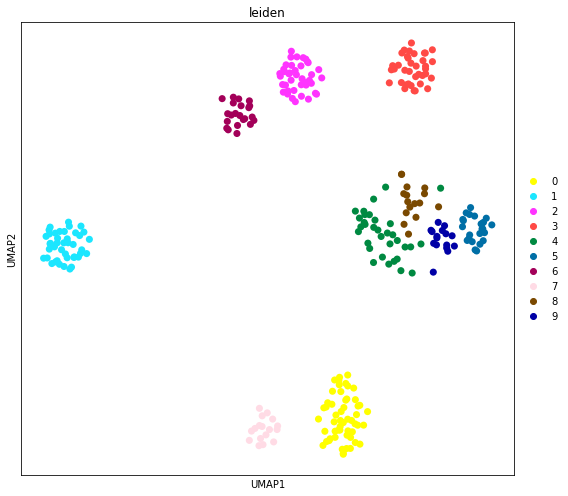

In [8]:
fig, axs = plt.subplots(figsize=(8, 7))

sc.pl.umap(
    adata,
    color="leiden",
    size=200,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    show=False,
    ax=axs,
)

plt.tight_layout()

We also visualize the annotated cell types in UMAP space.

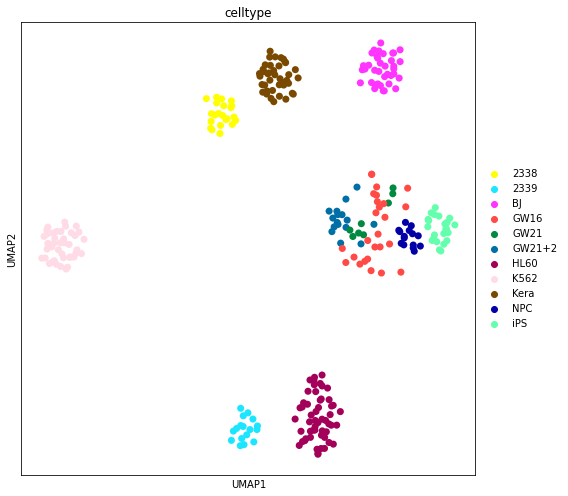

In [9]:
fig, axs = plt.subplots(figsize=(8, 7))

sc.pl.umap(
    adata,
    color="celltype",
    size=200,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    show=False,
    ax=axs,
)

plt.tight_layout()

## Cell type marker genes

Lastly, we compute the differentially expressed (DE) genes of each cell type for visualization.

In [10]:
sc.tl.rank_genes_groups(adata, groupby='celltype', method='t-test')

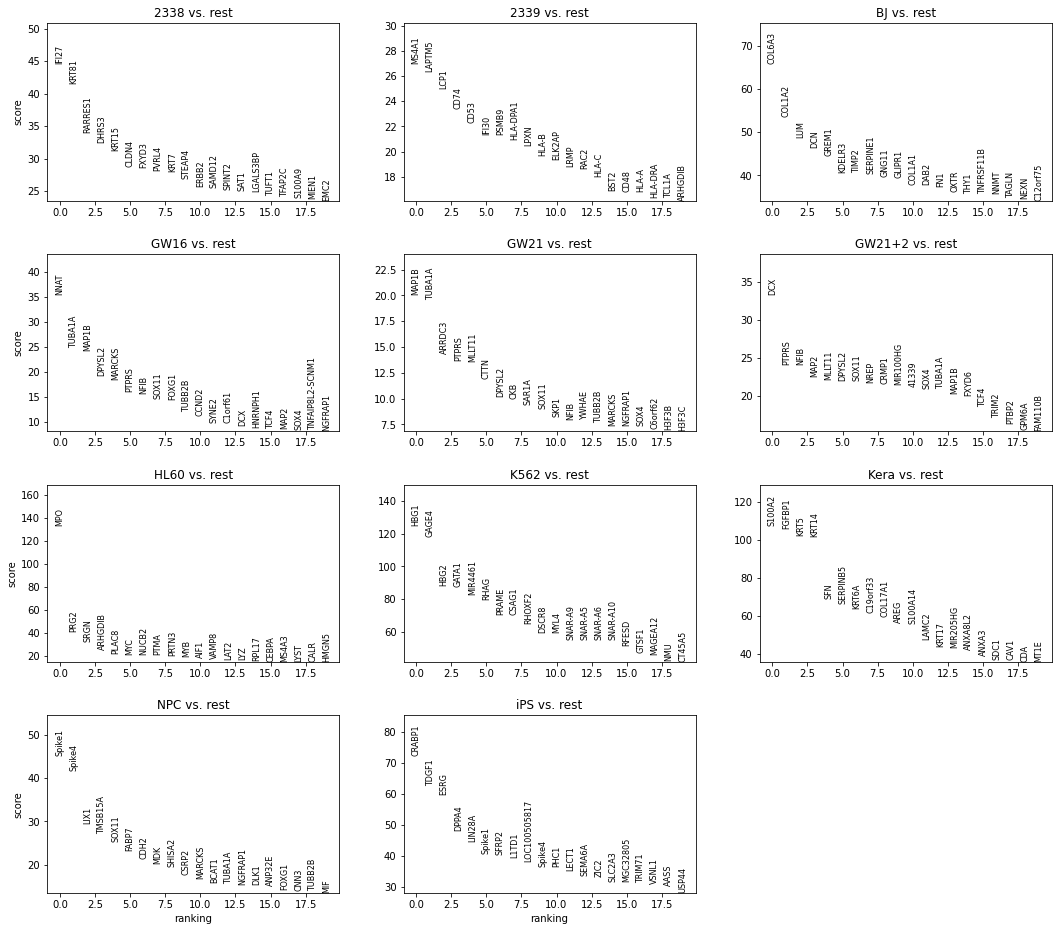

In [11]:
sc.pl.rank_genes_groups(adata, n_genes=20, ncols=3, sharey=False)

In [12]:
marker_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[:10,:]
marker_genes

,2338,2339,BJ,GW16,GW21,GW21+2,HL60,K562,Kera,NPC,iPS
0,IFI27,MS4A1,COL6A3,NNAT,MAP1B,DCX,MPO,HBG1,S100A2,Spike1,CRABP1
1,KRT81,LAPTM5,COL1A2,TUBA1A,TUBA1A,PTPRS,PRG2,GAGE4,FGFBP1,Spike4,TDGF1
2,RARRES1,LCP1,LUM,MAP1B,ARRDC3,NFIB,SRGN,HBG2,KRT5,LIX1,ESRG
3,DHRS3,CD74,DCN,DPYSL2,PTPRS,MAP2,ARHGDIB,GATA1,KRT14,TMSB15A,DPPA4
4,KRT15,CD53,GREM1,MARCKS,MLLT11,MLLT11,PLAC8,MIR4461,SFN,SOX11,LIN28A
5,CLDN4,IFI30,KDELR3,PTPRS,CTTN,DPYSL2,MYC,RHAG,SERPINB5,FABP7,Spike1
6,FXYD3,PSMB9,TIMP2,NFIB,DPYSL2,SOX11,NUCB2,PRAME,KRT6A,CDH2,SFRP2
7,PVRL4,HLA-DPA1,SERPINE1,SOX11,CKB,NREP,PTMA,CSAG1,C19orf33,MDK,L1TD1
8,KRT7,LPXN,GNG11,FOXG1,SAR1A,CRMP1,PRTN3,RHOXF2,COL17A1,SHISA2,LOC100505817
9,STEAP4,HLA-B,GLIPR1,TUBB2B,SOX11,MIR100HG,MYB,DSCR8,AREG,CSRP2,Spike4


Now, we focus on a specific cell type, here BJ for demonstration.

We visualize the expression levels of the first-ranked DE gene of BJ in UMAP space.

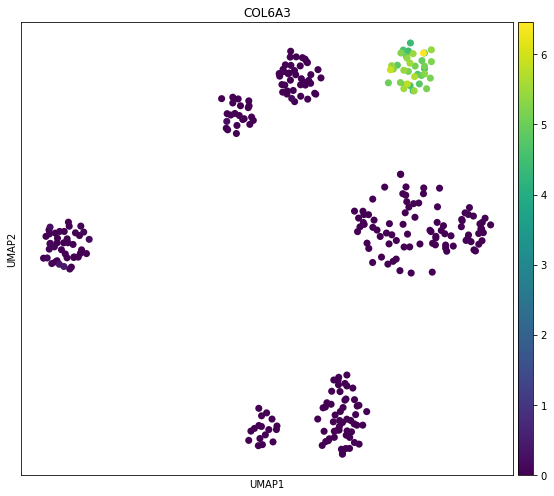

In [13]:
fig, axs = plt.subplots(figsize=(8, 7))

sc.pl.umap(
    adata,
    color=marker_genes.iloc[0,2],
    size=200,
    palette=sc.pl.palettes.default_20,
    legend_loc='right margin',
    show=False,
    ax=axs,
)

plt.tight_layout()

Then, we visualize the expression pattern of top 3 DE genes of each cell type.

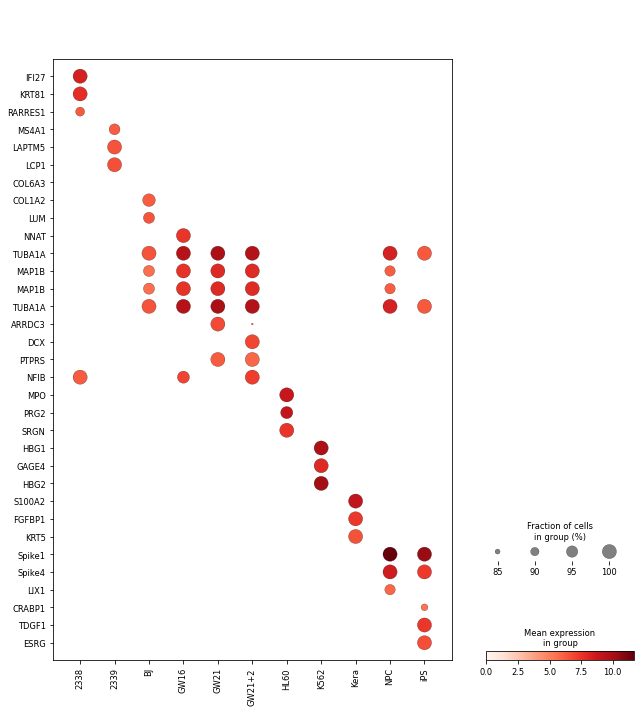

In [14]:
fig, axs = plt.subplots(figsize=(9, 10))

sc.pl.dotplot(
    adata,
    var_names=marker_genes.iloc[0:3, :].to_numpy().T.reshape(-1),
    groupby='celltype',
    expression_cutoff=5,
    dot_min=0.8,
    swap_axes=True,
    show=False,
    ax=axs,
)

plt.tight_layout()